# NDMS I: Fra data til klyngeanalyse

*Flipped classroom øvelse til valgfaget "Nyere digitale metoder i samfundsvidenskaben I", 2022*



I denne øvelse skal I udføre en klyngeanalyse på et udsnit af Den Danske Værdiundersøgelse 2017 (https://www.ddv.aau.dk/).

Data og kodebog kan findes på moodle.

Vi har givet jer data, som ikke er helt klar til analyse. Der vil være værdier, der skal kodes om, missingværdier, som skal håndteres og datasæt, som skal sættes sammen, før at I kan foretage en analyse.



## Øvelsen går ud på følgende:
1. Udvælg minimum 4 variable at udføre klyngeanalyse på.
2. Foretag den nødvendige datahåndtering for at kunne foretage en klyngeanalyse.
3. Foretag klyngeanalyse.
4. Udforsk resultatet af jeres klyngeanalyse med inddragelse af relevante baggrundsvariable (kræver at I sætter de to datasæt sammen).
5. Dan en visualisering, der kan bidrage til at forklare mønstre i jeres klynger.



**Værd at vide om data**

- Variabel- og værdilabels kan findes i kodebogen (ligger på moodle)
- `ipnr17` indeholder respondentens id-nummer
- Der er to datasæt:
  - `DDV2017_redux_qs.csv`: Indeholder svar på holdningsspørgsmålene
    - Direkte link: https://github.com/CALDISS-AAU/course_ndms-I/raw/master/datasets/DDV2017_redux_qs.csv
  - `DDV2017_redux_bcg.csv`: Indeholder baggrundsvariable for respondenterne
    - Direkte link: https://github.com/CALDISS-AAU/course_ndms-I/raw/master/datasets/DDV2017_redux_bcg.csv

In [39]:
## Pakker
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score
import seaborn as sns

sns.set()
plt.rcParams['figure.figsize'] = (20.0, 10.0)

In [2]:
## Indlæs data
ddv2017_qs = pd.read_csv("data/DDV2017_redux_qs.csv")

ddv2017_bcg = pd.read_csv("data/DDV2017_redux_bcg.csv")

In [3]:
## Tjek om data ser fint ud
ddv2017_qs.head()

,ipnr17,v65,v66,v67,v68,v69,v123,v124,v125,v126,...,v223,v224,v225,v226,v227,v228,v229,v230,v231,v232
0,FU489319,Nej,Nej,Nej,Nej,Nej,Ret stor tillid,Meget stor tillid,Ret stor tillid,Slet ingen tillid,...,I mindre grad,I mindre grad,Til en vis grad,I mindre grad,I mindre grad,Til en vis grad,Slet ikke vigtigt,Temmelig vigtigt,Temmelig vigtigt,Meget vigtigt
1,CZ218266,Ja,Nej,Nej,Nej,Nej,Ikke særlig stor tillid,Ikke særlig stor tillid,Ret stor tillid,Ikke særlig stor tillid,...,I nogen grad,I nogen grad,I høj grad,I nogen grad,I nogen grad,I høj grad,Temmelig vigtigt,Meget vigtigt,Ikke særlig vigtigt,Meget vigtigt
2,FU341483,Ja,Ja,Nej,Nej,Ja,Ret stor tillid,Ret stor tillid,Ret stor tillid,Slet ingen tillid,...,I høj grad,I høj grad,I høj grad,I høj grad,I høj grad,I høj grad,Temmelig vigtigt,Meget vigtigt,Temmelig vigtigt,Meget vigtigt
3,CZ442236,Ja,Ja,Nej,Nej,Nej,Ret stor tillid,Ret stor tillid,Ret stor tillid,Ikke særlig stor tillid,...,I mindre grad,I mindre grad,I nogen grad,Til en vis grad,Til en vis grad,I mindre grad,Temmelig vigtigt,Meget vigtigt,Temmelig vigtigt,Meget vigtigt
4,FU738103,Nej,Nej,Nej,Nej,Nej,Ret stor tillid,Ret stor tillid,Ret stor tillid,Ret stor tillid,...,I høj grad,I høj grad,I nogen grad,I nogen grad,I nogen grad,I nogen grad,Temmelig vigtigt,Meget vigtigt,Meget vigtigt,Temmelig vigtigt


In [4]:
## Danner liste med de kolonnenavne, som skal bruges til klyngeanalysen
cluster_cols = ['v65', 'v66', 'v67', 'v68', 'v69']

In [5]:
cluster_cols

['v65', 'v66', 'v67', 'v68', 'v69']

In [6]:
## Hvilke værdier skal rekodes? (alle fem variable er kodet ens)
ddv2017_qs['v66'].value_counts()

Nej                2028
Ja                 1220
Nægter at svare      79
Ved ikke             35
Name: v66, dtype: int64

In [7]:
## Mappings til rekodning
yes_no_mapping = {"Ja": 1, "Nej": 0}
missing_mapping = {"Nægter at svare": np.nan, "Ved ikke": np.nan}

In [13]:
## Danner subset - tilføjer ipnr17 med i subset, da det skal bruges i merge senere
ddv_subset = ddv2017_qs.loc[:, ["ipnr17"] + cluster_cols]

In [14]:
## Tjekker subset
ddv_subset.head()

,ipnr17,v65,v66,v67,v68,v69
0,FU489319,Nej,Nej,Nej,Nej,Nej
1,CZ218266,Ja,Nej,Nej,Nej,Nej
2,FU341483,Ja,Ja,Nej,Nej,Ja
3,CZ442236,Ja,Ja,Nej,Nej,Nej
4,FU738103,Nej,Nej,Nej,Nej,Nej


In [15]:
## Rekod variable med brug af for loop
for col in cluster_cols:
    ddv_subset[col] = ddv_subset[col].replace(yes_no_mapping)
    ddv_subset[col] = ddv_subset[col].replace(missing_mapping)

In [16]:
## Tjekker subset efter rekodning
ddv_subset.head()

,ipnr17,v65,v66,v67,v68,v69
0,FU489319,0.0,0.0,0.0,0.0,0.0
1,CZ218266,1.0,0.0,0.0,0.0,0.0
2,FU341483,1.0,1.0,0.0,0.0,1.0
3,CZ442236,1.0,1.0,0.0,0.0,0.0
4,FU738103,0.0,0.0,0.0,0.0,0.0


In [17]:
## Fjerner missing
print(ddv_subset.shape) # Hvor mange rækker i data før fjern af missing?

ddv_subset = ddv_subset.dropna() # Fjern missing

print(ddv_subset.shape) # Hvor mange rækker i data efter fjern af missing?


(3362, 6)
(3168, 6)


In [21]:
## Finder ud af, hvor mange klynger, som vi vil danne
cluster_set = ddv_subset.loc[:, cluster_cols]

for k in range(2,11):
    cluster = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='complete').fit(cluster_set)
    labels=cluster.labels_
    dbs=davies_bouldin_score(cluster_set, labels)
    dbs=round(dbs,2)
    ch = metrics.calinski_harabasz_score(cluster_set, labels)
    ch=round(ch,2)
    ss=metrics.silhouette_score(cluster_set, labels, metric='euclidean')
    ss=round(ss,2)
    print("Cluster count-", k, "|", " db score-", dbs, "|", " ch score - ", ch, "|", " ss score - ", ss)
    k=str(k)

Cluster count- 2 |  db score- 1.86 |  ch score -  675.27 |  ss score -  0.35
Cluster count- 3 |  db score- 1.26 |  ch score -  989.12 |  ss score -  0.44
Cluster count- 4 |  db score- 1.12 |  ch score -  1579.49 |  ss score -  0.55
Cluster count- 5 |  db score- 0.97 |  ch score -  1279.46 |  ss score -  0.56
Cluster count- 6 |  db score- 0.79 |  ch score -  1150.36 |  ss score -  0.57
Cluster count- 7 |  db score- 0.75 |  ch score -  986.78 |  ss score -  0.58
Cluster count- 8 |  db score- 0.91 |  ch score -  868.9 |  ss score -  0.58
Cluster count- 9 |  db score- 0.87 |  ch score -  764.29 |  ss score -  0.58
Cluster count- 10 |  db score- 0.84 |  ch score -  1026.7 |  ss score -  0.65


In [22]:
## 6 klynger virker som et godt bud. Laver klyngeanalyse igen for 6 klynger og tilføjer klyngetilhør som variabel

cluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='complete').fit(cluster_set)
labels = cluster.labels_
ddv_subset['cluster'] = labels

In [23]:
## Hvordan ser det ud?
ddv_subset.head()

,ipnr17,v65,v66,v67,v68,v69,cluster
0,FU489319,0.0,0.0,0.0,0.0,0.0,3
1,CZ218266,1.0,0.0,0.0,0.0,0.0,1
2,FU341483,1.0,1.0,0.0,0.0,1.0,1
3,CZ442236,1.0,1.0,0.0,0.0,0.0,1
4,FU738103,0.0,0.0,0.0,0.0,0.0,3


In [25]:
## Hvordan er fordelingen i klynger?
ddv_subset['cluster'].value_counts()

3    1422
1    1202
5     179
0     166
2     125
4      74
Name: cluster, dtype: int64

In [26]:
## Måske skulle antal klynger genovervejes givet de små klynger, men det gør vi ikke her.

In [27]:
## Merge af data. ipnr17 er både i subset med klyngetilhør og i data med baggrundsoplysninger

In [28]:
ddv_subset.head()

,ipnr17,v65,v66,v67,v68,v69,cluster
0,FU489319,0.0,0.0,0.0,0.0,0.0,3
1,CZ218266,1.0,0.0,0.0,0.0,0.0,1
2,FU341483,1.0,1.0,0.0,0.0,1.0,1
3,CZ442236,1.0,1.0,0.0,0.0,0.0,1
4,FU738103,0.0,0.0,0.0,0.0,0.0,3


In [30]:
ddv2017_bcg.head()

,ipnr17,v313_dk,v314_dk,v315_dk,alder,civilstand,børn,urbanisering,uddannelse,uddannelse_partner,uddannelse_mor,uddannelse_far,isco_fn,isco_p_fn,indkomst_kvint,parti,frivillig,folkekirken
0,FU489319,Secondary education,350.000<,Male,42.0,Gift eller reg. partnerskab,5 børn,NaN,Erhvervsfaglige uddannelser,Mellemlange vid. udd,Mellemlange vid. udd,Mellemlange vid. udd,4,4,5.0,Det Konservative Folkeparti,Ja,ja
1,CZ218266,Secondary education,250.000-350.000,Male,33.0,Papirløst partnerskab,2 børn,Mellemstore byer,Erhvervsfaglige uddannelser,Korte vid. udd,Mellemlange vid. udd,Erhvervsfaglige uddannelser,2,3,4.0,Dansk Folkeparti,Nej,ja
2,FU341483,Secondary education,350.000<,Male,63.0,Papirløst partnerskab,Ingen børn,NaN,Mellemlange vid. udd,Mellemlange vid. udd,Grundskole og gym.,Grundskole og gym.,4,4,5.0,Det Konservative Folkeparti,Nej,ja
3,CZ442236,Secondary education,<150.0000,Female,21.0,Papirløst partnerskab,Ingen børn,De 3 store provinsbyer,Grundskole og gym.,Grundskole og gym.,Erhvervsfaglige uddannelser,Erhvervsfaglige uddannelser,1,3,1.0,NaN,Nej,ja
4,FU738103,"Long-cycle tertiary eduation, Ph.D",350.000<,Male,60.0,Gift eller reg. partnerskab,2 børn,NaN,Lang vid. udd,Lang vid. udd,Grundskole og gym.,Erhvervsfaglige uddannelser,4,4,5.0,Det Radikale Venstre,Ja,nej


In [31]:
## Brug af pd.merge til at sammensætte (se video for flere detaljer om denne)
ddv_subset_m = pd.merge(ddv_subset, ddv2017_bcg, how = "left", on = "ipnr17")

In [32]:
## Hvordan ser det ud?
ddv_subset_m.head()

,ipnr17,v65,v66,v67,v68,v69,cluster,v313_dk,v314_dk,v315_dk,...,uddannelse,uddannelse_partner,uddannelse_mor,uddannelse_far,isco_fn,isco_p_fn,indkomst_kvint,parti,frivillig,folkekirken
0,FU489319,0.0,0.0,0.0,0.0,0.0,3,Secondary education,350.000<,Male,...,Erhvervsfaglige uddannelser,Mellemlange vid. udd,Mellemlange vid. udd,Mellemlange vid. udd,4,4,5.0,Det Konservative Folkeparti,Ja,ja
1,CZ218266,1.0,0.0,0.0,0.0,0.0,1,Secondary education,250.000-350.000,Male,...,Erhvervsfaglige uddannelser,Korte vid. udd,Mellemlange vid. udd,Erhvervsfaglige uddannelser,2,3,4.0,Dansk Folkeparti,Nej,ja
2,FU341483,1.0,1.0,0.0,0.0,1.0,1,Secondary education,350.000<,Male,...,Mellemlange vid. udd,Mellemlange vid. udd,Grundskole og gym.,Grundskole og gym.,4,4,5.0,Det Konservative Folkeparti,Nej,ja
3,CZ442236,1.0,1.0,0.0,0.0,0.0,1,Secondary education,<150.0000,Female,...,Grundskole og gym.,Grundskole og gym.,Erhvervsfaglige uddannelser,Erhvervsfaglige uddannelser,1,3,1.0,NaN,Nej,ja
4,FU738103,0.0,0.0,0.0,0.0,0.0,3,"Long-cycle tertiary eduation, Ph.D",350.000<,Male,...,Lang vid. udd,Lang vid. udd,Grundskole og gym.,Erhvervsfaglige uddannelser,4,4,5.0,Det Radikale Venstre,Ja,nej


In [34]:
## Udforsk resultater. 
## Gennemsnitsalder i klynger

ddv_subset_m.groupby('cluster')['alder'].mean()

cluster
0    48.436364
1    50.119900
2    54.360000
3    47.507736
4    45.270270
5    55.430168
Name: alder, dtype: float64

In [35]:
## Kønsfordeling

ddv_subset_m.groupby('cluster')['v315_dk'].value_counts()

cluster  v315_dk
0        Male        84
         Female      82
1        Female     695
         Male       507
2        Female      83
         Male        42
3        Male       819
         Female     603
4        Female      37
         Male        37
5        Female     116
         Male        63
Name: v315_dk, dtype: int64

<AxesSubplot:xlabel='cluster'>

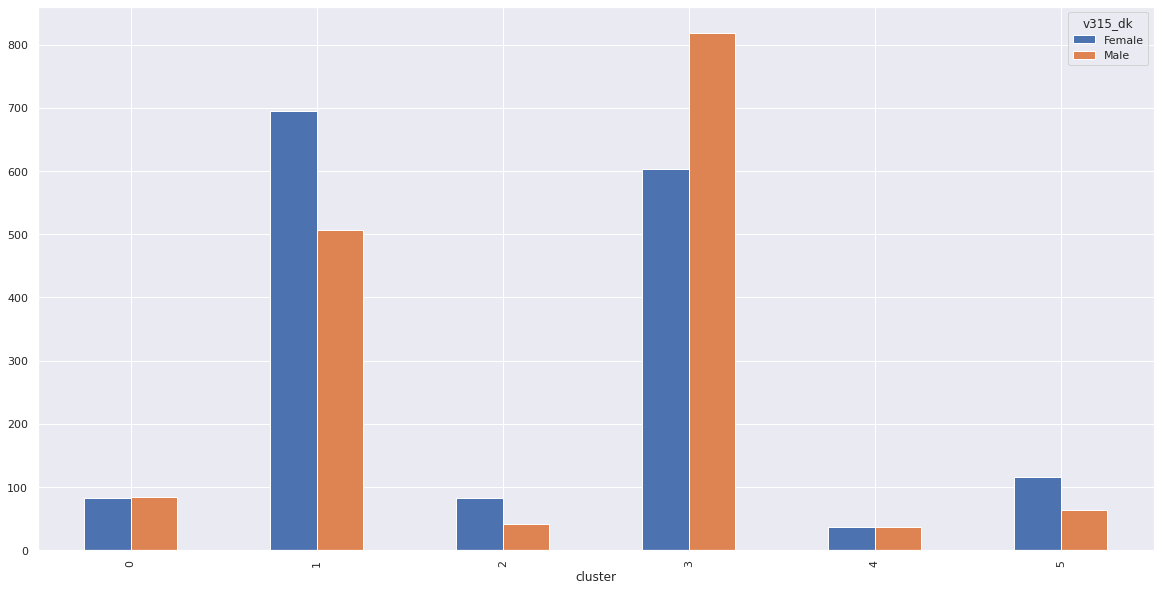

In [41]:
## Kønsfordeling - Visualiseret

ddv_subset_m.groupby('cluster')['v315_dk'].value_counts().unstack().plot.bar()

<AxesSubplot:xlabel='cluster'>

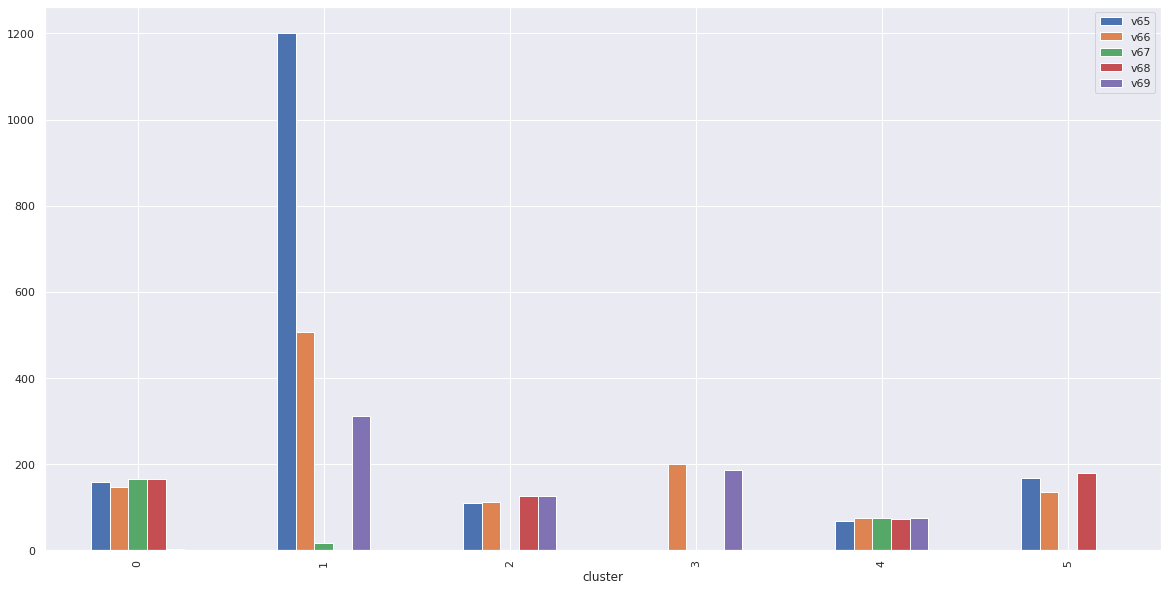

In [45]:
## Hvor mange har svaret "Ja" i de forskellige spørgsmål?
## "Ja" er kodet 1, mens "Nej" er kodet 0, så summen af variablene svarer til, hvor mange der har svaret "Ja"

ddv_subset_m.groupby('cluster')[cluster_cols].sum().plot.bar()